# RecogNYCe

## Project Description
See [README](./README.md)

## Code

In [121]:
!pip install shapely
!pip install geopandas
!pip install aiohttp
!pip install aiofiles
#!pip install numpy
#!pip install pandas
#!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for mapillary from https://files.pythonhosted.org/packages/4b/07/c4ccd6677e29ab87bd4cb4ace7b0b3c216596eb9116a6d9f608d262916e3/mapillary-1.0.12-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.5/283.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import shapely
import pandas as pd
import geopandas as gpd
from utils.geojson_utils import Neighborhoods

### Location Data Exploration

Loading boroughs
len(nb.neighborhoods) = 5
Plotting boroughs


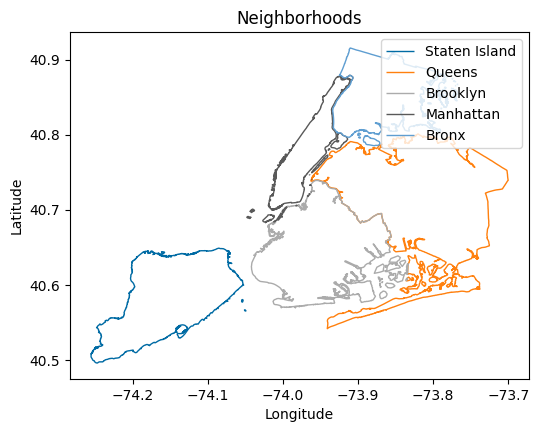

Sampling boroughs
Plotting samples


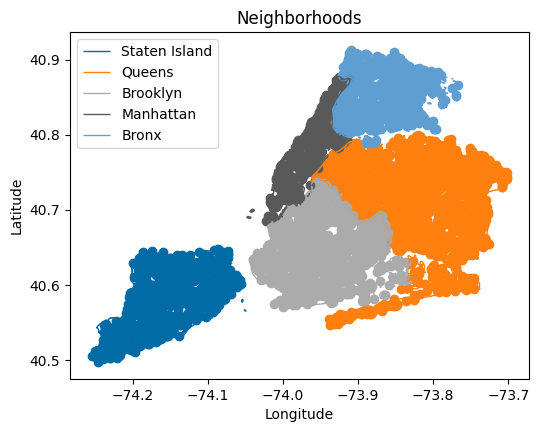

In [40]:
location_dir = "./data/location/"
geo_file = "nyc_boroughs.geojson"
geo_path = os.path.join(location_dir, geo_file)

# Load geojson file
print("Loading boroughs")
nb = Neighborhoods()
nb.load_geojson(geo_path)

print(f"{len(nb.neighborhoods) = }")

# Plot zones
print("Plotting boroughs")
ax = nb.plot()
ax.legend()
plt.show()

# Sample coordinates in neighborhoods
print("Sampling boroughs")
samples = nb.generate_samples(n_points=10000)

# Plot samples
print("Plotting samples")
ax = nb.plot()
ax.legend()
plt.show()

### Scraping street-level image data from coordinates

#### Mapillary

In [41]:
data_dir = "./data/mapillary"
csv_path = os.path.join(data_dir, "data.csv")
append_first = False
radius=50

for i, (neighborhood, coords) in enumerate(zip(nb.neighborhood_names, nb.neighborhood_samples)):
    print(f"Downloading images for {neighborhood} - trying {len(coords)} coordinates")
    results = await download_images_async(coords, neighborhood, data_dir=data_dir, radius=radius, verbose=False)
    append_results = i > 0 or append_first
    results.to_csv(csv_path, index=False, header=not append_results, mode="a" if append_results else "w")
    print(f"Downloaded {len(results)} images")

Downloaded 116 images
Downloaded 426 images


In [ ]:
dataset = pandas.read_csv(csv_path)
dataset.head(10)